https://t.me/Sputnik_results

In [1]:
    
import nest_asyncio
nest_asyncio.apply()

## Часть 1 

In [2]:
import telethon
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
# скрипт для скачивания сообщений из Telegram, создает файл channel_messages.json

import configparser
import json

from telethon.sync import TelegramClient
from telethon import connection

# для корректного переноса времени сообщений в json
from datetime import date, datetime

# классы для работы с каналами
from telethon.tl.functions.channels import GetParticipantsRequest
from telethon.tl.types import ChannelParticipantsSearch

# класс для работы с сообщениями
from telethon.tl.functions.messages import GetHistoryRequest

# Присваиваем значения внутренним переменным
api_id = 11714810
api_hash = '606543eec30b6153863d9c098e8166f1'
username = 'TiMeLeSs05'

client = TelegramClient(username, api_id, api_hash)
client.start()


async def dump_all_participants(channel):
	"""Записывает json-файл с информацией о всех участниках канала/чата"""
	offset_user = 0    # номер участника, с которого начинается считывание
	limit_user = 100   # максимальное число записей, передаваемых за один раз

	all_participants = []   # список всех участников канала
	filter_user = ChannelParticipantsSearch('')

	while True:
		participants = await client(GetParticipantsRequest(channel,
			filter_user, offset_user, limit_user, hash=0))
		if not participants.users:
			break
		all_participants.extend(participants.users)
		offset_user += len(participants.users)

	all_users_details = []   # список словарей с интересующими параметрами участников канала

	for participant in all_participants:
		all_users_details.append({"id": participant.id,
			"first_name": participant.first_name,
			"last_name": participant.last_name,
			"user": participant.username,
			"phone": participant.phone,
			"is_bot": participant.bot})

	with open('channel_users.json', 'w', encoding='utf8') as outfile:
		json.dump(all_users_details, outfile, ensure_ascii=False)


async def dump_all_messages(channel):
	"""Записывает json-файл с информацией о всех сообщениях канала/чата"""
	offset_msg = 0    # номер записи, с которой начинается считывание
	limit_msg = 100   # максимальное число записей, передаваемых за один раз

	all_messages = []   # список всех сообщений
	total_messages = 0
	total_count_limit = 0  # поменяйте это значение, если вам нужны не все сообщения

	class DateTimeEncoder(json.JSONEncoder):
		'''Класс для сериализации записи дат в JSON'''
		def default(self, o):
			if isinstance(o, datetime):
				return o.isoformat()
			if isinstance(o, bytes):
				return list(o)
			return json.JSONEncoder.default(self, o)

	while True:
		history = await client(GetHistoryRequest(
			peer=channel,
			offset_id=offset_msg,
			offset_date=None, add_offset=0,
			limit=limit_msg, max_id=0, min_id=0,
			hash=0))
		if not history.messages:
			break
		messages = history.messages
		for message in messages:
			all_messages.append(message.to_dict())
		offset_msg = messages[len(messages) - 1].id
		total_messages = len(all_messages)
		if total_count_limit != 0 and total_messages >= total_count_limit:
			break

	with open('channel_messages.json', 'w', encoding='utf8') as outfile:
		 json.dump(all_messages, outfile, ensure_ascii=False, cls=DateTimeEncoder)


async def main():
	url = input("Введите ссылку на канал или чат: ")
	channel = await client.get_entity(url)
	#await dump_all_participants(channel)
	await dump_all_messages(channel)


async with client:
	client.loop.run_until_complete(main())
	#client.close()
	#client.disconnect()

c:\Users\Elizaveta\text_2\venv\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: coroutine 'AuthMethods._start' was never awaited


Signed in successfully as Elizaveta


In [4]:
mess_df = pd.read_json('channel_messages.json', encoding='utf8')
#print(mess_df.columns)

No handles with labels found to put in legend.


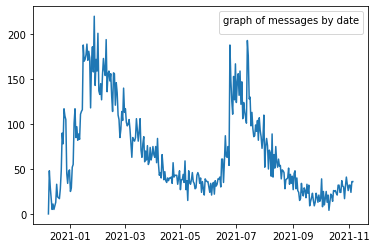

In [5]:
# Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты.
mess_df['date'] = pd.to_datetime(mess_df['date'])
mess_df['only_date'] = mess_df['date'].dt.date
df_1 = mess_df.groupby('only_date')['message'].count()
plt.plot(df_1)
plt.legend(title = 'graph of messages by date')
plt.show()

Видно, что всплески вакцинации были зимой и летом(по данным из телеграмм)

No handles with labels found to put in legend.


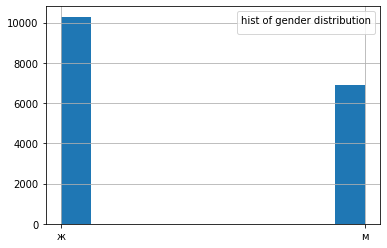

In [6]:
## Часть 2
# 1.
# Функция для извлечения пола участника из сообщений
def get_sex(text):
    if pd.notna(text):
        pattern = re.compile(r'\b[МмЖж]..?\d\d|\b[МмЖж]\d\d|\b[Жж]ен.+\d\d\B|\b[Мм]уж.+\d\d\B|[Жж]енщина|[Мм]ужчина')
        listsexs = pattern.findall(text)
        list_to_write = [i[0].lower() for i in listsexs]
        return list_to_write
    return []

mess_df['sex'] = mess_df.message.apply(lambda mess: get_sex(mess))
mess_df['sex'].explode().hist()
plt.legend(title = 'hist of gender distribution')
plt.show()

Вывод: женщин привилось больше(по данным из телеграмм)

No handles with labels found to put in legend.


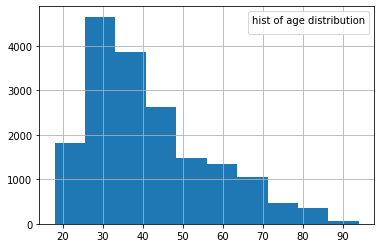

In [7]:
# Функция для извлечения возраста участника из сообщений
def get_age(text):
    if pd.notna(text):
        pattern = re.compile(r'\b[МмЖж]..?\d\d|\b[МмЖж]\d\d|\b\d\d\sгода?|\b\d\d\sлет')
        listage = pattern.findall(text)
        list_to_write = []
        for i in listage:
            if i[-2:].isalpha():
                list_to_write.append(int(i[:2]))
            else:
                list_to_write.append(int(i[-2:]))
        return list_to_write
    return None

mess_df['age'] = mess_df.message.apply(lambda mess: get_age(mess))
df_temp = mess_df['age'].explode().sort_values()
df_temp[df_temp >= 18].hist()
plt.legend(title = 'hist of age distribution')
plt.show()

Вывод: людей среднего возраста(25-35 лет) привилось больше всего

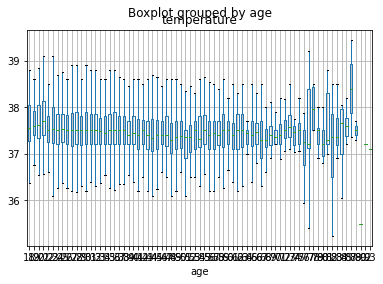

In [9]:
# 2. Зависимость повышения температуры от возраста людей
def get_temp(text):
    if pd.notna(text):
        sumtemp = 0
        pattern = re.compile(r'3\d[.,]\d')
        listtemp = pattern.findall(text)
        if len(listtemp) != 0:
            for i in listtemp:
                if i[2] == ',':
                    i = ('.').join(i.split(','))
                sumtemp += float(i)
            mean_temp = sumtemp / len(listtemp)
        else:
            return None

        return mean_temp
    return None

mess_df['temperature'] = mess_df.message.apply(lambda x: get_temp(x))
mess_df = mess_df.explode('age')
dff = mess_df[(mess_df.temperature >= 35) & (mess_df.age >= 18)][['temperature', 'age']]
dff.boxplot(column='temperature', by='age', showfliers=False)
plt.show()

Вывод: медианная температура у людей в среднем у всех до 37.5(что видно по boxplot)